<a href="https://colab.research.google.com/github/ronnief1/Polyp-Segmentation/blob/main/encoder_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libs
! pip install catalyst==19.04rc1

### please update Albumentations to latest version for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations@bdd6a4e
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading data

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from catalyst.dl.utils import UtilsFactory
import albumentations as albu
import torch
import numpy as np
import gc
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from catalyst.dl.callbacks import EarlyStoppingCallback
from catalyst.dl.experiments import SupervisedRunner
import collections
from catalyst.dl.callbacks import InferCallback, CheckpointCallback

In [4]:
DATA_DIR = './drive/MyDrive/ColabNotebooks/AppliedDeepLearning/Kvasir-SEG/output/'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [6]:
# helper function for data visualization
def visualize(save=False, folder=None, number=None, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        if save:
          plt.savefig(folder + '/predicted' + str(number) + '.jpg')     
    plt.show()

### Dataloader

In [7]:
class Dataset(BaseDataset):
    """Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['polyp', 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask[np.where(mask < 8)] = 0
        mask[np.where(mask > 8)] = 255
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

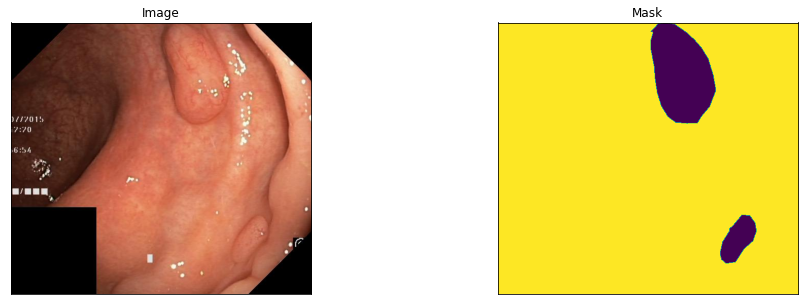

In [8]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['polyp'])

image, mask = dataset[5] # get some sample
visualize(save=True, folder='./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/', number='0',
    image=image, 
    mask=mask.squeeze(),
)

### Augmentations

In [9]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.RandomCrop(height=320, width=320, always_apply=True, p=1),
        
        albu.Resize(576, 736, always_apply=True, p=1),
        

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #lbu.PadIfNeeded(384, 480)
        albu.Resize(576, 736)
        #albu.RandomCrop(height=320, width=320, always_apply=True, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [10]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['polyp', 'background'],
)

# same image with different random transforms
#for i in range(5):
#    image, mask = augmented_dataset[1]
#    visualize(image=image, mask=mask)

## Create model and train

In [11]:
# try different params for UNet++ function
# aux_params=dict(
#     pooling='avg',             # one of 'avg', 'max'
#     dropout=0.5,               # dropout ratio, default is None
#     activation='sigmoid',      # activation function, default is None
#     classes=4,                 # define number of output labels
# )
# model = smp.Unet('resnet34', classes=4, aux_params=aux_params)

In [12]:
encoders = ['resnet34', 'efficientnet-b0', 'mobilenet_v2', 'timm-gernet_s']

running model with timm-gernet_s


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-ger-weights/gernet_s-756b4751.pth" to /root/.cache/torch/hub/checkpoints/gernet_s-756b4751.pth


  0%|          | 0.00/31.4M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1734: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even fr

0/10 * Epoch (train): 100% 200/200 [01:54<00:00,  1.75it/s, _fps=124.459, loss=0.580]
0/10 * Epoch (valid): 100% 100/100 [00:31<00:00,  3.20it/s, _fps=1.069, loss=0.437]
[2022-11-12 14:56:38,089] 
0/10 * Epoch 0 (train): _fps=72.4461 | base/batch_time=0.1676 | base/data_time=0.0668 | base/lr=0.0010 | base/model_time=0.1008 | base/momentum=0.9000 | loss=0.5306
0/10 * Epoch 0 (valid): _fps=36.5956 | base/batch_time=0.2848 | base/data_time=0.2570 | base/lr=0.0010 | base/model_time=0.0278 | base/momentum=0.9000 | loss=0.4474


INFO:metrics:
0/10 * Epoch 0 (train): _fps=72.4461 | base/batch_time=0.1676 | base/data_time=0.0668 | base/lr=0.0010 | base/model_time=0.1008 | base/momentum=0.9000 | loss=0.5306
0/10 * Epoch 0 (valid): _fps=36.5956 | base/batch_time=0.2848 | base/data_time=0.2570 | base/lr=0.0010 | base/model_time=0.0278 | base/momentum=0.9000 | loss=0.4474


1/10 * Epoch (train): 100% 200/200 [01:40<00:00,  2.00it/s, _fps=122.040, loss=0.553]
1/10 * Epoch (valid): 100% 100/100 [00:06<00:00, 16.34it/s, _fps=51.086, loss=0.425]
[2022-11-12 14:58:26,272] 
1/10 * Epoch 1 (train): _fps=66.6719 | base/batch_time=0.1064 | base/data_time=0.0606 | base/lr=0.0010 | base/model_time=0.0457 | base/momentum=0.9000 | loss=0.5220
1/10 * Epoch 1 (valid): _fps=30.0712 | base/batch_time=0.0405 | base/data_time=0.0173 | base/lr=0.0010 | base/model_time=0.0231 | base/momentum=0.9000 | loss=0.4367


INFO:metrics:
1/10 * Epoch 1 (train): _fps=66.6719 | base/batch_time=0.1064 | base/data_time=0.0606 | base/lr=0.0010 | base/model_time=0.0457 | base/momentum=0.9000 | loss=0.5220
1/10 * Epoch 1 (valid): _fps=30.0712 | base/batch_time=0.0405 | base/data_time=0.0173 | base/lr=0.0010 | base/model_time=0.0231 | base/momentum=0.9000 | loss=0.4367


2/10 * Epoch (train): 100% 200/200 [01:40<00:00,  1.99it/s, _fps=113.475, loss=0.479]
2/10 * Epoch (valid): 100% 100/100 [00:06<00:00, 16.28it/s, _fps=54.957, loss=0.427]
[2022-11-12 15:00:14,871] 
2/10 * Epoch 2 (train): _fps=69.2687 | base/batch_time=0.1035 | base/data_time=0.0621 | base/lr=0.0010 | base/model_time=0.0414 | base/momentum=0.9000 | loss=0.5166
2/10 * Epoch 2 (valid): _fps=30.0757 | base/batch_time=0.0402 | base/data_time=0.0173 | base/lr=0.0010 | base/model_time=0.0228 | base/momentum=0.9000 | loss=0.4366


INFO:metrics:
2/10 * Epoch 2 (train): _fps=69.2687 | base/batch_time=0.1035 | base/data_time=0.0621 | base/lr=0.0010 | base/model_time=0.0414 | base/momentum=0.9000 | loss=0.5166
2/10 * Epoch 2 (valid): _fps=30.0757 | base/batch_time=0.0402 | base/data_time=0.0173 | base/lr=0.0010 | base/model_time=0.0228 | base/momentum=0.9000 | loss=0.4366


3/10 * Epoch (train): 100% 200/200 [01:40<00:00,  1.99it/s, _fps=105.872, loss=0.526]
3/10 * Epoch (valid): 100% 100/100 [00:06<00:00, 16.25it/s, _fps=54.584, loss=0.424]
[2022-11-12 15:02:03,701] 
3/10 * Epoch 3 (train): _fps=69.2189 | base/batch_time=0.1008 | base/data_time=0.0601 | base/lr=0.0010 | base/model_time=0.0407 | base/momentum=0.9000 | loss=0.5134
3/10 * Epoch 3 (valid): _fps=30.0054 | base/batch_time=0.0405 | base/data_time=0.0167 | base/lr=0.0010 | base/model_time=0.0238 | base/momentum=0.9000 | loss=0.4343


INFO:metrics:
3/10 * Epoch 3 (train): _fps=69.2189 | base/batch_time=0.1008 | base/data_time=0.0601 | base/lr=0.0010 | base/model_time=0.0407 | base/momentum=0.9000 | loss=0.5134
3/10 * Epoch 3 (valid): _fps=30.0054 | base/batch_time=0.0405 | base/data_time=0.0167 | base/lr=0.0010 | base/model_time=0.0238 | base/momentum=0.9000 | loss=0.4343


4/10 * Epoch (train): 100% 200/200 [01:40<00:00,  2.00it/s, _fps=126.078, loss=0.452]
4/10 * Epoch (valid): 100% 100/100 [00:06<00:00, 16.03it/s, _fps=49.502, loss=0.418]
[2022-11-12 15:03:52,357] 
4/10 * Epoch 4 (train): _fps=70.0558 | base/batch_time=0.0997 | base/data_time=0.0578 | base/lr=0.0010 | base/model_time=0.0419 | base/momentum=0.9000 | loss=0.5157
4/10 * Epoch 4 (valid): _fps=28.3984 | base/batch_time=0.0421 | base/data_time=0.0163 | base/lr=0.0010 | base/model_time=0.0257 | base/momentum=0.9000 | loss=0.4307


INFO:metrics:
4/10 * Epoch 4 (train): _fps=70.0558 | base/batch_time=0.0997 | base/data_time=0.0578 | base/lr=0.0010 | base/model_time=0.0419 | base/momentum=0.9000 | loss=0.5157
4/10 * Epoch 4 (valid): _fps=28.3984 | base/batch_time=0.0421 | base/data_time=0.0163 | base/lr=0.0010 | base/model_time=0.0257 | base/momentum=0.9000 | loss=0.4307


5/10 * Epoch (train): 100% 200/200 [01:40<00:00,  1.99it/s, _fps=124.584, loss=0.561]
5/10 * Epoch (valid): 100% 100/100 [00:06<00:00, 15.97it/s, _fps=53.506, loss=0.419]
[2022-11-12 15:05:41,160] 
5/10 * Epoch 5 (train): _fps=70.7603 | base/batch_time=0.1001 | base/data_time=0.0592 | base/lr=0.0010 | base/model_time=0.0409 | base/momentum=0.9000 | loss=0.5089
5/10 * Epoch 5 (valid): _fps=29.2955 | base/batch_time=0.0416 | base/data_time=0.0178 | base/lr=0.0010 | base/model_time=0.0238 | base/momentum=0.9000 | loss=0.4293


INFO:metrics:
5/10 * Epoch 5 (train): _fps=70.7603 | base/batch_time=0.1001 | base/data_time=0.0592 | base/lr=0.0010 | base/model_time=0.0409 | base/momentum=0.9000 | loss=0.5089
5/10 * Epoch 5 (valid): _fps=29.2955 | base/batch_time=0.0416 | base/data_time=0.0178 | base/lr=0.0010 | base/model_time=0.0238 | base/momentum=0.9000 | loss=0.4293


6/10 * Epoch (train): 100% 200/200 [01:41<00:00,  1.97it/s, _fps=95.121, loss=0.586]
6/10 * Epoch (valid): 100% 100/100 [00:06<00:00, 15.96it/s, _fps=42.834, loss=0.421]
[2022-11-12 15:07:30,928] 
6/10 * Epoch 6 (train): _fps=67.0799 | base/batch_time=0.1064 | base/data_time=0.0618 | base/lr=0.0010 | base/model_time=0.0446 | base/momentum=0.9000 | loss=0.5047
6/10 * Epoch 6 (valid): _fps=29.2259 | base/batch_time=0.0418 | base/data_time=0.0177 | base/lr=0.0010 | base/model_time=0.0240 | base/momentum=0.9000 | loss=0.4276


INFO:metrics:
6/10 * Epoch 6 (train): _fps=67.0799 | base/batch_time=0.1064 | base/data_time=0.0618 | base/lr=0.0010 | base/model_time=0.0446 | base/momentum=0.9000 | loss=0.5047
6/10 * Epoch 6 (valid): _fps=29.2259 | base/batch_time=0.0418 | base/data_time=0.0177 | base/lr=0.0010 | base/model_time=0.0240 | base/momentum=0.9000 | loss=0.4276


7/10 * Epoch (train): 100% 200/200 [01:40<00:00,  1.99it/s, _fps=116.513, loss=0.647]
7/10 * Epoch (valid): 100% 100/100 [00:06<00:00, 16.10it/s, _fps=58.053, loss=0.416]
[2022-11-12 15:09:19,914] 
7/10 * Epoch 7 (train): _fps=72.9421 | base/batch_time=0.1026 | base/data_time=0.0648 | base/lr=0.0010 | base/model_time=0.0377 | base/momentum=0.9000 | loss=0.5088
7/10 * Epoch 7 (valid): _fps=30.2391 | base/batch_time=0.0409 | base/data_time=0.0175 | base/lr=0.0010 | base/model_time=0.0233 | base/momentum=0.9000 | loss=0.4250


INFO:metrics:
7/10 * Epoch 7 (train): _fps=72.9421 | base/batch_time=0.1026 | base/data_time=0.0648 | base/lr=0.0010 | base/model_time=0.0377 | base/momentum=0.9000 | loss=0.5088
7/10 * Epoch 7 (valid): _fps=30.2391 | base/batch_time=0.0409 | base/data_time=0.0175 | base/lr=0.0010 | base/model_time=0.0233 | base/momentum=0.9000 | loss=0.4250


8/10 * Epoch (train): 100% 200/200 [01:41<00:00,  1.97it/s, _fps=116.853, loss=0.462]
8/10 * Epoch (valid): 100% 100/100 [00:06<00:00, 15.97it/s, _fps=49.907, loss=0.417]
[2022-11-12 15:11:09,024] 
8/10 * Epoch 8 (train): _fps=68.5289 | base/batch_time=0.1053 | base/data_time=0.0636 | base/lr=0.0010 | base/model_time=0.0417 | base/momentum=0.9000 | loss=0.5020
8/10 * Epoch 8 (valid): _fps=30.0705 | base/batch_time=0.0407 | base/data_time=0.0170 | base/lr=0.0010 | base/model_time=0.0236 | base/momentum=0.9000 | loss=0.4256


INFO:metrics:
8/10 * Epoch 8 (train): _fps=68.5289 | base/batch_time=0.1053 | base/data_time=0.0636 | base/lr=0.0010 | base/model_time=0.0417 | base/momentum=0.9000 | loss=0.5020
8/10 * Epoch 8 (valid): _fps=30.0705 | base/batch_time=0.0407 | base/data_time=0.0170 | base/lr=0.0010 | base/model_time=0.0236 | base/momentum=0.9000 | loss=0.4256


9/10 * Epoch (train): 100% 200/200 [01:39<00:00,  2.01it/s, _fps=111.261, loss=0.518]
9/10 * Epoch (valid): 100% 100/100 [00:06<00:00, 15.67it/s, _fps=49.705, loss=0.416]
[2022-11-12 15:12:56,237] 
9/10 * Epoch 9 (train): _fps=71.9112 | base/batch_time=0.0966 | base/data_time=0.0608 | base/lr=0.0010 | base/model_time=0.0357 | base/momentum=0.9000 | loss=0.5047
9/10 * Epoch 9 (valid): _fps=29.0431 | base/batch_time=0.0421 | base/data_time=0.0175 | base/lr=0.0010 | base/model_time=0.0245 | base/momentum=0.9000 | loss=0.4255


INFO:metrics:
9/10 * Epoch 9 (train): _fps=71.9112 | base/batch_time=0.0966 | base/data_time=0.0608 | base/lr=0.0010 | base/model_time=0.0357 | base/momentum=0.9000 | loss=0.5047
9/10 * Epoch 9 (valid): _fps=29.0431 | base/batch_time=0.0421 | base/data_time=0.0175 | base/lr=0.0010 | base/model_time=0.0245 | base/momentum=0.9000 | loss=0.4255


Top best models:
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/encoder_logs/segmentation_notebooktimm-gernet_s/checkpoints//train.7.pth	0.4250
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/encoder_logs/segmentation_notebooktimm-gernet_s/checkpoints//train.9.pth	0.4255
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/encoder_logs/segmentation_notebooktimm-gernet_s/checkpoints//train.8.pth	0.4256
=> loading checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/encoder_logs/segmentation_notebooktimm-gernet_s/checkpoints/best.pth"
loaded checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/encoder_logs/segmentation_notebooktimm-gernet_s/checkpoints/best.pth" (epoch 7)


Top best models:



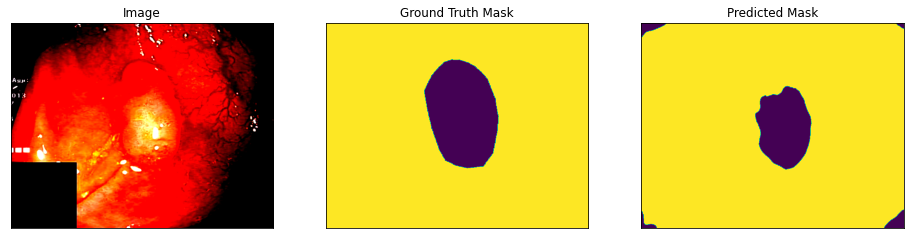

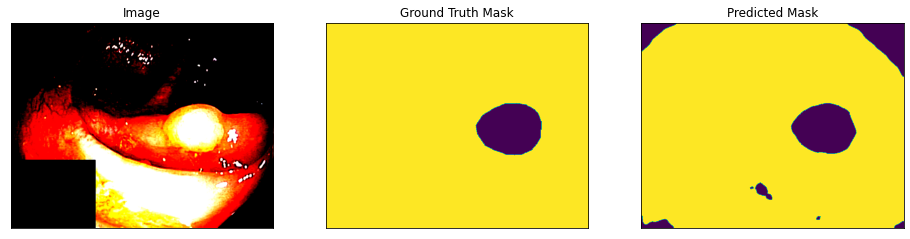

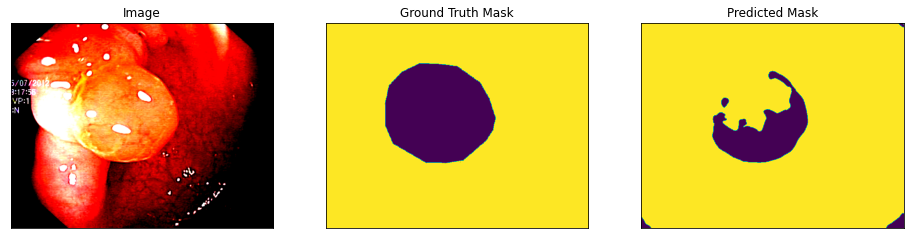

In [13]:
for encoder in encoders:
  ENCODER = encoder
  logdir = "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/encoder_logs/segmentation_notebook" + encoder

  if not os.path.exists(logdir):
    os.makedirs(logdir)

  #check if folder already has jpg file. if so, model already trained and test set inferred. need to skip
  #if no jpg file: run rest of for loop
  if not any(File.endswith(".jpg") for File in os.listdir(logdir)):
    print('running model with ' + ENCODER)
    ENCODER_WEIGHTS = 'imagenet'
    DEVICE = 'cuda'

    CLASSES = ['polyp', 'background']
    ACTIVATION = 'sigmoid'

    # create segmentation model with pretrained encoder
    model = smp.UnetPlusPlus(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
        
    )
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    train_dataset = Dataset(
        x_train_dir, 
        y_train_dir, 
        augmentation=get_training_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CLASSES,
    )

    valid_dataset = Dataset(
        x_valid_dir, 
        y_valid_dir, 
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CLASSES,
    )

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

    # experiment setup
    num_epochs = 10  
    logdir = "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/encoder_logs/segmentation_notebook" + encoder
    UtilsFactory.plot_metrics(logdir=logdir)
    loaders = {
        "train": train_loader,
        "valid": valid_loader
    }

    # model, criterion, optimizer
    # model = # already defined
    criterion = smp.losses.DiceLoss(mode='binary')  #BCEDiceLoss(eps=1.)
    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': 1e-4}, 
        
        # decrease lr for encoder in order not to permute 
        # pre-trained weights with large gradients on training start
        {'params': model.encoder.parameters(), 'lr': 1e-6},  
    ])
    scheduler = None

    # @TODO: add metrics support 
    # (catalyst expects logits, rather than sigmoid outputs)
    #metrics = [
    #     smp.  metrics.iou_score() 
        #IoUMetric(eps=1.),
        #smp.utils.metrics.FscoreMetric(eps=1.),
    #]


    # model runner
    runner = SupervisedRunner()

    # model training
    runner.train(
        model=model,
        criterion=criterion,
        callbacks=[
            EarlyStoppingCallback(
                patience=3, metric="loss", minimize=True
            )
        ],
        optimizer=optimizer,
        loaders=loaders,
        logdir=logdir,
        num_epochs=num_epochs,
        verbose=True
    )

    # create test dataset
    test_dataset = Dataset(
        x_test_dir, 
        y_test_dir, 
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CLASSES,
    )

    test_dataloader = DataLoader(test_dataset)

    loaders = {"infer": test_dataloader}
    runner.infer(
        model=model,
        loaders=loaders,
        callbacks=[
            CheckpointCallback(
                resume=f"{logdir}/checkpoints/best.pth"),
            InferCallback()
        ],
    )

    threshold = 0.5
    break_at = 2
    
    j = 0
    for i, (input, output) in enumerate(zip(
            test_dataset, runner.callbacks[1].predictions["logits"])):
        image, mask = input
        
        image_vis = image.transpose(1, 2, 0)
        gt_mask = mask[0].astype('uint8')
        pr_mask = (output[0] > threshold).astype('uint8')
            
        visualize(save=True, folder=logdir, number=j,
            image=image_vis, 
            ground_truth_mask=gt_mask, 
            predicted_mask=pr_mask
        )
        j = j + 1
        
        if i >= break_at:
          break
    torch.cuda.empty_cache()
    del model
    gc.collect()